# Recurrent Neural Networks
Simple Pytorch LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import time

import os


Load the raw data stored in the specified ``csv`` file and inspect the overall data format. Our input is a sequence of closing prices of the stock, and the output is the closing price of the next day. This can be changed

In [2]:
filepath = 'AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(os.path.join('data', filepath))
data = data.sort_values('Date')
data.head()


FileNotFoundError: [Errno 2] No such file or directory: 'data/AMZN_2006-01-01_to_2018-01-01.csv'

Plot the raw data.

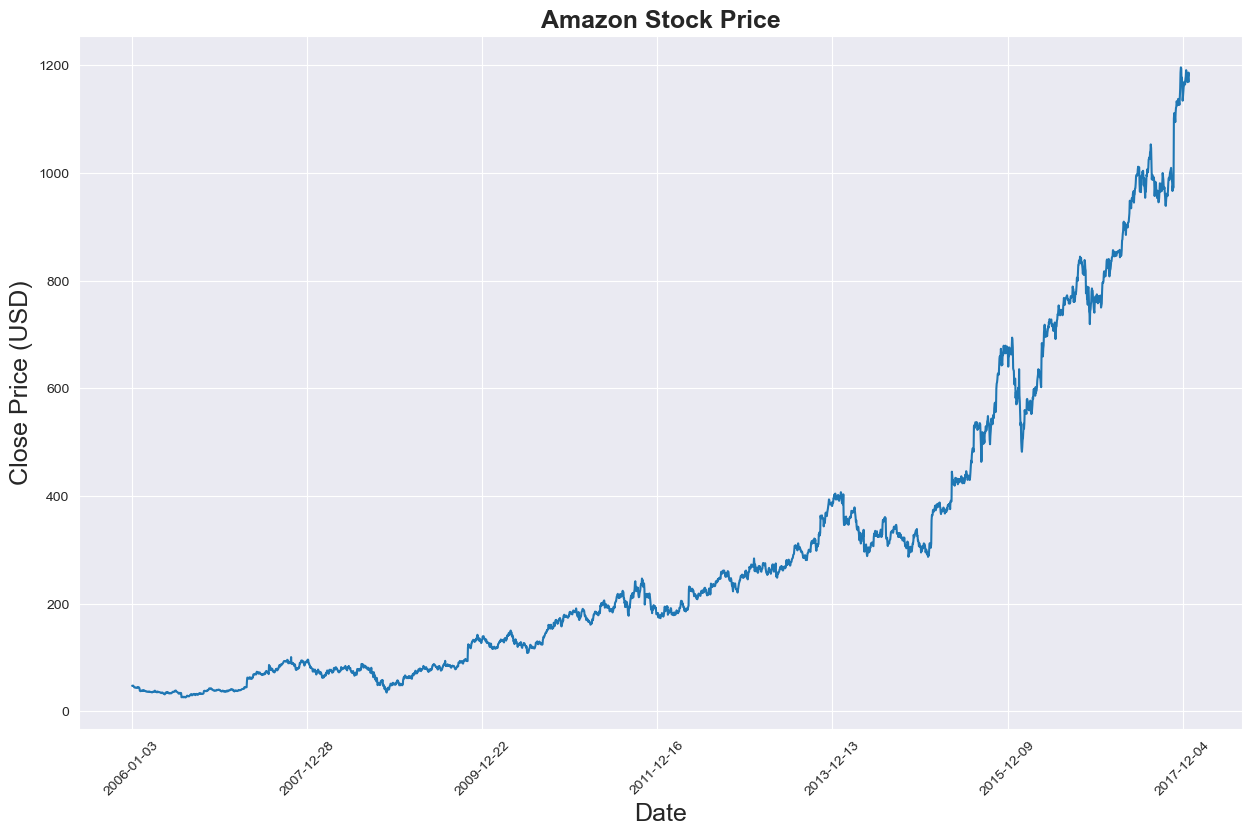

In [59]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


Extract the ``Close`` column in the data frame as our data.

In [60]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


Normalize the raw data into the range of ``[-1, 1]``.

In [61]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/g5/dfwv37r13p54dmy66xm4mj3h0000gq/T/ipykernel_8331/3221609643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following method helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [62]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [63]:
# process the raw data
lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


Convert from ``numpy.array`` to ``torch.tensor``.

In [64]:
# Convert to torch Tensor
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()


Here provides the hyper-parameters for the assignment. You can try changing these hyper-parameters and observe the difference in the model's performance.

In [1]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100
learning_rate = 0.01

NameError: name 'torch' is not defined

## Built-in LSTM

1-layer LSTM network using the PyTorch built-in LSTM cell

In [73]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm_cell = nn.LSTMCell(input_dim, hidden_dim, bias=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        ht = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()
        ct = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()

        for t in range(x.shape[1]):
            ht, ct = self.lstm_cell(x[:,t], (ht, ct))
        out = self.fc(ht) 
        return out

In [74]:
lstm_model = LSTM(input_dim, hidden_dim, 1, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [75]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = lstm_model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5936684608459473
Epoch  1 MSE:  0.39325985312461853
Epoch  2 MSE:  0.21670718491077423
Epoch  3 MSE:  0.03787325695157051
Epoch  4 MSE:  0.6661403179168701
Epoch  5 MSE:  0.04176115244626999
Epoch  6 MSE:  0.05069194734096527
Epoch  7 MSE:  0.10657214373350143
Epoch  8 MSE:  0.1392172873020172
Epoch  9 MSE:  0.15322495996952057
Epoch  10 MSE:  0.15480270981788635
Epoch  11 MSE:  0.1480880230665207
Epoch  12 MSE:  0.13572219014167786
Epoch  13 MSE:  0.11945817619562149
Epoch  14 MSE:  0.10060229897499084
Epoch  15 MSE:  0.08036766201257706
Epoch  16 MSE:  0.060233041644096375
Epoch  17 MSE:  0.042404595762491226
Epoch  18 MSE:  0.03043076954782009
Epoch  19 MSE:  0.02947775088250637
Epoch  20 MSE:  0.041118036955595016
Epoch  21 MSE:  0.050349701195955276
Epoch  22 MSE:  0.049581050872802734
Epoch  23 MSE:  0.04299817606806755
Epoch  24 MSE:  0.035991039127111435
Epoch  25 MSE:  0.031153667718172073
Epoch  26 MSE:  0.028742235153913498
Epoch  27 MSE:  0.0280880592763423

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

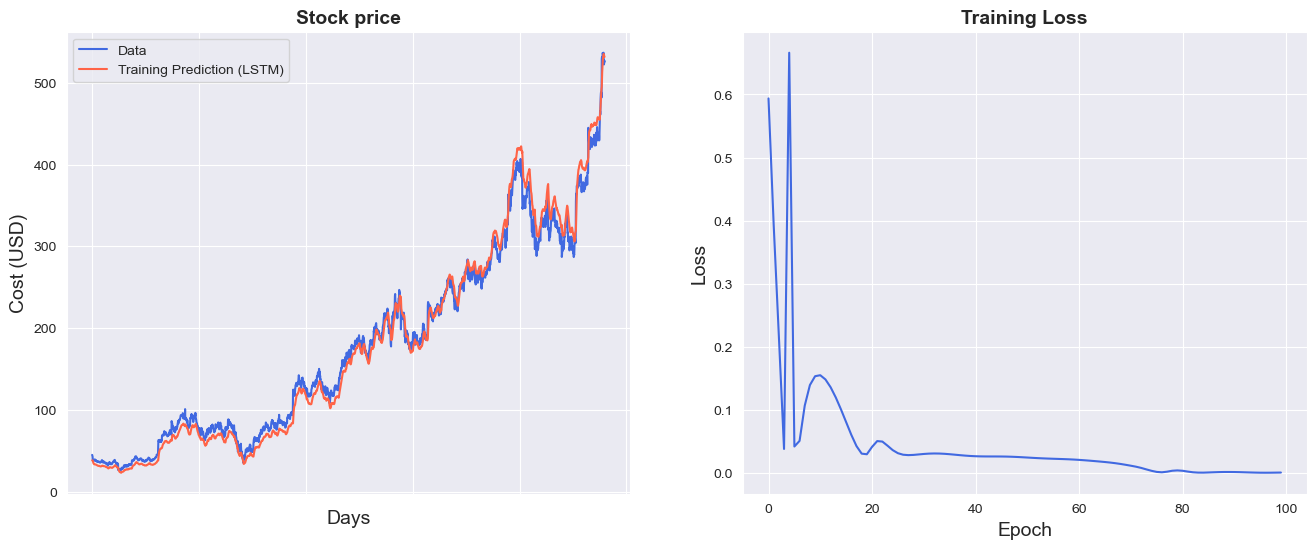

In [76]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

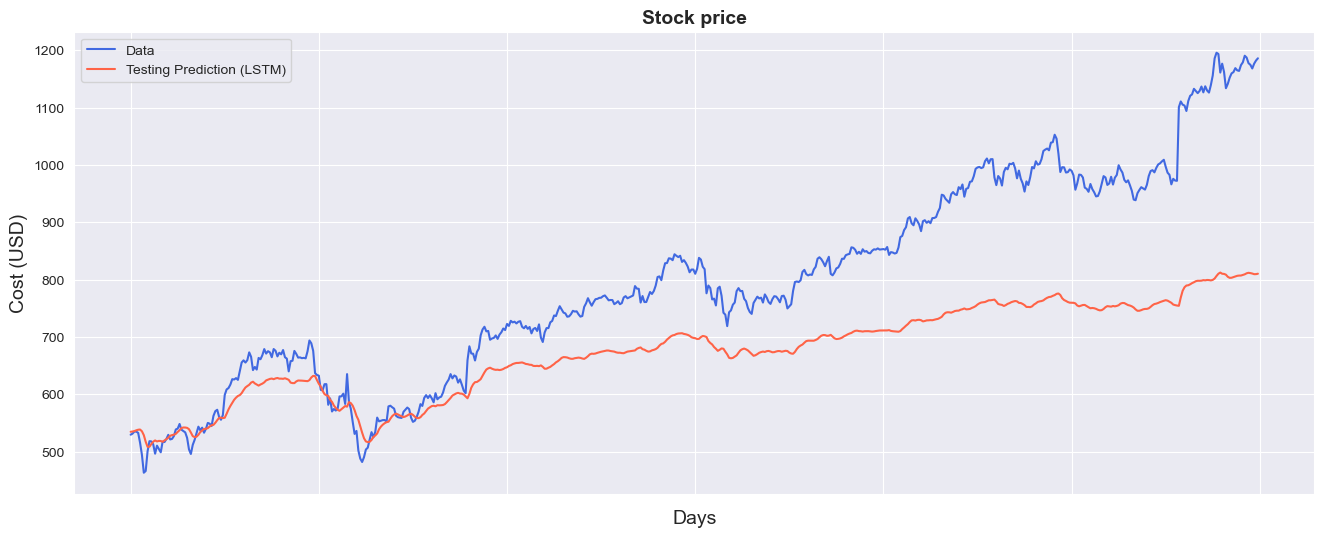

In [77]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = lstm_model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

In [78]:
# calculate root mean squared error
y_train2 = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test2 = y_test.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.27 RMSE


## Built-in GRU

1-layer GRU network using the PyTorch built-in GRU cell.

In [79]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru_cell = nn.GRUCell(input_dim, hidden_dim, bias=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        ht = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()

        for t in range(x.shape[1]):
            ht = self.gru_cell(x[:,t], ht)
        out = self.fc(ht) 
        return out

In [80]:
gru_model = GRU(input_dim, hidden_dim, 1, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

In [81]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = gru_model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.499340295791626
Epoch  1 MSE:  0.22772829234600067
Epoch  2 MSE:  0.05553528666496277
Epoch  3 MSE:  0.06248217821121216
Epoch  4 MSE:  0.05187225714325905
Epoch  5 MSE:  0.01886160671710968
Epoch  6 MSE:  0.025016918778419495
Epoch  7 MSE:  0.03592902421951294
Epoch  8 MSE:  0.0355403833091259
Epoch  9 MSE:  0.026003988459706306
Epoch  10 MSE:  0.016054799780249596
Epoch  11 MSE:  0.01439690962433815
Epoch  12 MSE:  0.020974362269043922
Epoch  13 MSE:  0.02262856811285019
Epoch  14 MSE:  0.016375528648495674
Epoch  15 MSE:  0.010955165140330791
Epoch  16 MSE:  0.010766306892037392
Epoch  17 MSE:  0.013352238573133945
Epoch  18 MSE:  0.01457258127629757
Epoch  19 MSE:  0.012643063440918922
Epoch  20 MSE:  0.009017367847263813
Epoch  21 MSE:  0.006706771906465292
Epoch  22 MSE:  0.007279638200998306
Epoch  23 MSE:  0.008795238099992275
Epoch  24 MSE:  0.008046720176935196
Epoch  25 MSE:  0.005198513623327017
Epoch  26 MSE:  0.003368455683812499
Epoch  27 MSE:  0.0039731

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

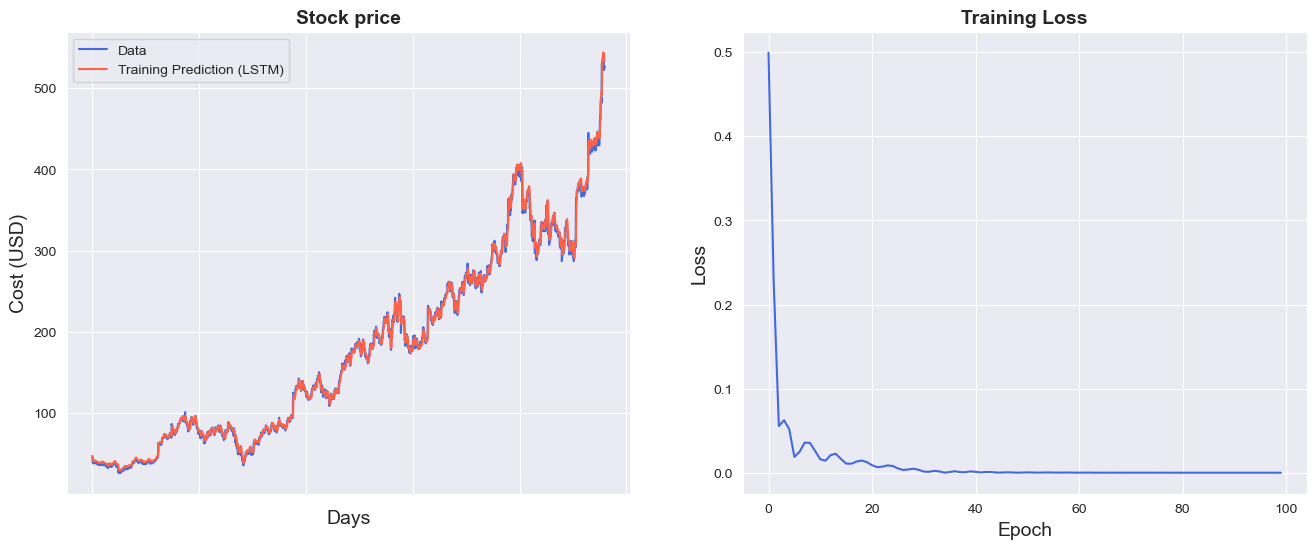

In [82]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

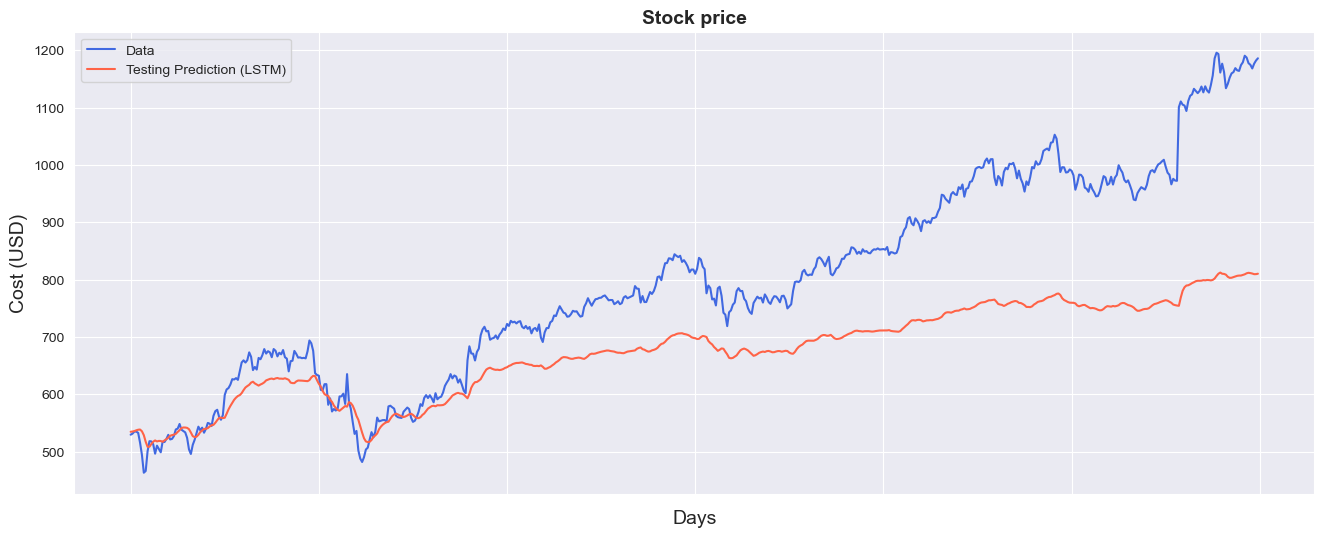

In [83]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = lstm_model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)